In [3]:
library(data.table)
library(dplyr)
library(ggplot2)
library(glue)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
library('scphaser')
data(marinov)
acset = new_acset(
    featdata = marinov[['featdata']], refcount = marinov[['refcount']],
    altcount = marinov[['altcount']], phenodata = marinov[['phenodata']]
)
acset = call_gt(acset)
acset = filter_acset(acset)
# acset = phase(acset)
# head(acset[['phasedfeat']])

In [8]:
df = fread(glue('~/external/MDA/TNBC4_N_allele_counts.tsv.gz'), sep = '\t')

In [12]:
sample = 'TNBC4'
cell_annot = fread('~/external/MDA/cell_annot.tsv') %>% 
    split(.$sample)
haplo_truth = readRDS('~/results/benchmark/haplotype_truth.rds')

In [9]:
normal_cells = cell_annot[['TNBC4']] %>% filter(copykat.pred == 'T') %>% pull(cell)
df_normal = df %>% filter(cell %in% normal_cells) %>% filter(!is.na(gene) & gene != '')

In [13]:
df_chr = df_normal %>%
    filter(snp_id %in% haplo_truth$snp_id) %>%
    mutate(h_c = ifelse(AD == 0, 0, 1))

featdata = df_chr %>% select(feat = gene, var = snp_id, ref = REF, alt = ALT) %>% distinct %>% data.frame()
rownames(featdata) = featdata$var
phenodata = df_chr %>% select(sample = cell) %>% distinct %>% as.data.frame
rownames(phenodata) = phenodata$sample

altcount = df_chr %>% dcast(snp_id~cell, value.var = 'AD', fill = 0) %>% tibble::column_to_rownames('snp_id') %>% as.matrix
refcount = df_chr %>% mutate(RD = DP - AD) %>% dcast(snp_id~cell, value.var = 'RD', fill = 0) %>% tibble::column_to_rownames('snp_id') %>% as.matrix

altcount = altcount[featdata$var,phenodata$sample]
refcount = refcount[featdata$var,phenodata$sample]
totalcount = (refcount + altcount)

In [30]:
acset = new_acset(featdata, refcount, altcount, phenodata)
acset = filter_feat_nminvar(acset, 2)
acset = call_gt(acset, min_acount = 1, fc = 3)

In [19]:
acset = phase(acset, input = 'gt', weigh = FALSE, method = 'exhaust', verbosity = 1)

In [25]:
library(BiocParallel)

In [31]:
acset = phase(acset, input = 'ac', weigh = FALSE, method = 'exhaust', verbosity = 1, bp_param = MulticoreParam(workers = 30))

# Evaluate accuracy

In [27]:
acset$phasedfeat %>%
inner_join(haplo_truth, by = c('var' = 'snp_id')) %>%
mutate(haplo_exp = ifelse(hapA == alt, 'A', 'B')) %>%
{table(.$haplo_truth, .$haplo_exp)}

       
           A    B
  major  267 4961
  minor  266 4603

In [33]:
acset$phasedfeat %>%
inner_join(haplo_truth, by = c('var' = 'snp_id')) %>%
mutate(haplo_exp = ifelse(hapA == alt, 'major', 'minor')) %>%
mutate(
    config = haplo_exp == haplo_truth
) %>%
rename(gene = feat, snp_id = var) %>%
group_by(CHROM, gene) %>%
filter(n() > 1) %>%
mutate(
    switch = c(NA, config[2:length(config)] != config[1:(length(config)-1)])
) %>%
ungroup() %>%
summarise(
    accuracy = signif(1-mean(na.omit(switch)),3)
)

accuracy
<dbl>
0.718


In [21]:
acset$phasedfeat %>%
inner_join(haplo_truth, by = c('var' = 'snp_id')) %>%
mutate(haplo_exp = ifelse(hapA == alt, 'major', 'minor')) %>%
mutate(
    config = haplo_exp == haplo_truth
) %>%
rename(gene = feat, snp_id = var) %>%
group_by(CHROM, gene) %>%
filter(n() > 1) %>%
mutate(
    switch = c(NA, config[2:length(config)] != config[1:(length(config)-1)])
) %>%
ungroup() %>%
summarise(
    accuracy = signif(1-mean(na.omit(switch)),3)
)

accuracy
<dbl>
0.718


In [22]:
acset$phasedfeat %>%
inner_join(haplo_truth, by = c('var' = 'snp_id')) %>%
mutate(haplo_exp = ifelse(hapA == alt, 'major', 'minor')) %>%
mutate(
    config = haplo_exp == haplo_truth
) %>%
rename(gene = feat, snp_id = var) %>%
group_by(CHROM, gene) %>%
filter(row_number() == 1 | row_number() == n()) %>%
group_by(CHROM) %>%
mutate(
    switch = c(NA, config[2:length(config)] != config[1:(length(config)-1)])
) %>%
group_by(CHROM, gene) %>%
filter(row_number() == 1) %>%
ungroup() %>%
summarise(
    accuracy = 1-mean(na.omit(switch))
)

accuracy
<dbl>
0.5177206


In [351]:
snp_x = '3_3128394_C_G'
snp_y = '3_3129282_T_C'

table(totalcount[snp_x,] > 0, totalcount[snp_y,] > 0)

       
        FALSE TRUE
  FALSE  1090   14
  TRUE     84    4

In [391]:
fisher.test(table(totalcount[snp_x,] > 0, totalcount[snp_y,] > 0))


	Fisher's Exact Test for Count Data

data:  table(totalcount[snp_x, ] > 0, totalcount[snp_y, ] > 0)
p-value = 0.03814
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8677564 12.1331775
sample estimates:
odds ratio 
  3.700456 


In [519]:
n = nrow(totalcount)
# n = 5

joint_counts = sapply(
    1:(n-1),
    function(i) {sum(totalcount[i,] > 0 & totalcount[i+1,] > 0)}
)

In [463]:
calc_binom_p = function(snp_x, snp_y, df) {
    
    counts = df_chr %>%
        filter(snp_id %in% c(snp_x, snp_y)) %>%
        group_by(cell) %>%
        filter(n() > 1) 
    
    if (nrow(counts) > 0) {
        res = counts %>%
            reshape2::dcast(cell ~ snp_index, value.var = 'h_c') %>%
            setNames(c('cell', 'snp_x', 'snp_y')) %>%
            mutate(
                snp_x = as.integer(snp_x),
                snp_y = as.integer(snp_y),
                cis = snp_x == snp_y
            ) %>%
            summarise(p = binom.test(x = sum(cis), n = n())$p.value)
        return(res$p)
    }
    
}

In [468]:
snp_x

[1] "3_3128394_C_G"

In [503]:
i = 4
counts = altcount[c(i,i+1),totalcount[i,] > 0 & totalcount[i+1,] > 0]
configs = counts[1,] == counts[2,]

In [510]:
n = nrow(totalcount)-1

pvals = sapply(
    1:(n-1),
    function(i) {
        counts = altcount[c(i,i+1),totalcount[i,] > 0 & totalcount[i+1,] > 0, drop = F]
        if (length(counts) > 0) {
            configs = counts[1,] == counts[2,]
            binom.test(sum(configs), length(configs))$p.value   
        } else {
            return(1)
        }
    }
)

In [517]:
joint_counts %>% length

[1] 13873

In [518]:
pvals %>% length

[1] 10864

In [521]:
mean(joint_counts > 1)

[1] 0.1597791

In [514]:
mean(pvals < 0.05)

[1] 0.05532032

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 38 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”


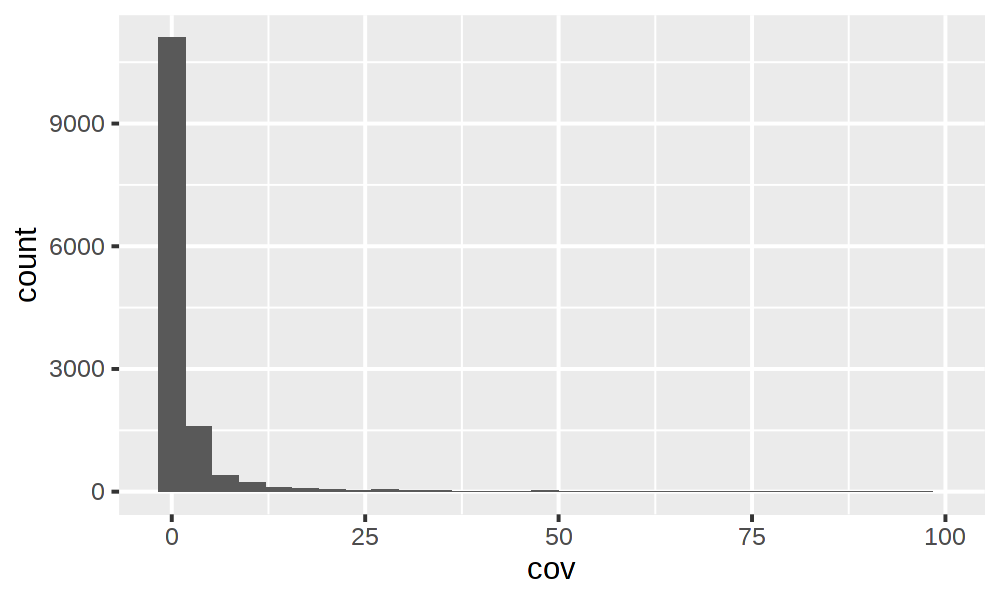

In [386]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)

data.frame(cov = joint_counts) %>%
ggplot(aes(x = cov)) +
geom_histogram() +
xlim(NA,100)

In [390]:
mean(joint_counts > 1)

[1] 0.2003172